In [2]:
library(circlize)
library(ComplexHeatmap)
library(data.table)

In [3]:
trans_dir = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_Plasma_tophits_multianno/"
trans_files = paste0(trans_dir,list.files(trans_dir))
head(trans_files,2)

[1] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_Plasma_tophits_multianno/A1BG_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"
[2] "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/from_wei/trans_Plasma_tophits_multianno/AAAS_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt"

In [4]:
gene_locs_file = "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/GeneLocations.tsv"
gene_loc = fread(gene_locs_file)
head(gene_loc)

gene_name,gene_id,seqid,start,end,strand
<chr>,<chr>,<chr>,<int>,<int>,<chr>
AL627309.1,ENSG00000237683,1,134901,139379,-
AL669831.1,ENSG00000269831,1,738532,739137,-
AL645608.2,ENSG00000269308,1,818043,819983,+
AL645608.1,ENSG00000268179,1,861264,866445,-
AL645728.1,ENSG00000215014,1,1510355,1511373,+
AL590822.2,ENSG00000269554,1,2121237,2123179,+


In [5]:
gene_files = list.files(paste0(trans_dir,"merged/"), pattern=".merged.txt")
length(gene_files)
head(gene_files,2)

[1] 5484

[1] "A1BG_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"
[2] "AAAS_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt"

In [6]:
genes = gsub("_Plasma_count_gw_allchr.txt_result.tophits.annovar.txt.hg19_multianno.txt.merged.txt", "", gene_files)
length(genes)
head(genes)

[1] 5484

[1] "A1BG"  "AAAS"  "AAGAB" "AAK1"  "AAMDC" "AAR2"

In [7]:
df_list = list()
for (i in 1:length(genes)){
    gene = genes[i]
    chrom = gene_loc[gene_loc$gene_name == gene,"seqid"]$seqid[1]
    gene_start = gene_loc[gene_loc$gene_name == gene,"start"]$start[1]
    gene_end = gene_loc[gene_loc$gene_name == gene,"end"]$end[1]
    file = paste0(trans_dir,"merged/",gene_files[i])
    df = as.data.frame(fread(file))
    if (nrow(df)==0){next}
    colnames(df)[(ncol(df)-2):ncol(df)] <- c("p.value","neg.log10.p.value","cis.trans")
    # filter to genome-wide significance
    df = df[df$p.value < 5e-8,]
    if (nrow(df)==0){next}
    # remove HLA region (https://www.ncbi.nlm.nih.gov/grc/human/regions/MHC?asm=GRCh37)
    df = df[!(df$Chr==6 & df$Start >= 28477797 & df$Start <= 33448354),]
    if (nrow(df)==0){next}
    colnames(df)[1:5] <- paste0("snp_",colnames(df)[1:5])
    df$gene_chr = chrom
    df$gene_start = gene_start
    df$gene_end = gene_end
    df$window_start = max(0,min(gene_start, gene_end)-2000000)
    df$window_end = max(gene_start, gene_end)+2000000
    df$gene = gene
    df_list[[gene]] = df
}
df_combine = rbindlist(df_list)

In [8]:
nrow(df_combine)
head(df_combine)

[1] 399

snp_Chr,snp_Start,snp_End,snp_Ref,snp_Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,⋯,SiPhy_29way_logOdds,p.value,neg.log10.p.value,cis.trans,gene_chr,gene_start,gene_end,window_start,window_end,gene
<int>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<chr>
1,200942385,200942385,G,A,UTR3,KIF21B,NM_001252102:c.*264C>T;NM_001252100:c.*838C>T;NM_001252103:c.*264C>T;NM_017596:c.*838C>T,NA,NA,⋯,NA,1.23524e-09,8.908249,potential_novel,4,146019084,146050331,144019084,148050331,ABCE1
10,99204791,99204791,G,A,intronic,EXOSC1,,NA,NA,⋯,NA,4.69299e-08,7.328550,potential_novel,15,89630690,89745591,87630690,91745591,ABHD2
16,53438426,53438426,C,G,intergenic,LOC102723373;RBL2,dist=20255;dist=29957,NA,NA,⋯,NA,3.77032e-08,7.423622,potential_novel,7,140372953,140396061,138372953,142396061,ADCK2
2,202851978,202851978,C,A,intergenic,CDK15;FZD7,dist=91705;dist=47332,NA,NA,⋯,NA,3.65461e-09,8.437159,potential_novel,19,42387228,42434302,40387228,44434302,ARHGEF1
2,142528988,142528988,G,C,intronic,LRP1B,,NA,NA,⋯,NA,2.63239e-08,7.579650,potential_novel,19,19144384,19170563,17144384,21170563,ARMC6
8,54396078,54396078,G,T,intergenic,OPRK1;LOC100507516,dist=231821;dist=28263,NA,NA,⋯,NA,4.65608e-08,7.331980,potential_novel,12,14518610,14651697,12518610,16651697,ATF7IP


In [9]:
# create a matrix, SNP chromosome by gene chromosome
mat=as.matrix(table(df_combine$snp_Chr, df_combine$gene_chr))
rownames(mat)
colnames(mat)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22"

[1] "1"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "2"  "20" "22" "3" 
[16] "4"  "5"  "6"  "7"  "8"  "9"

In [10]:
# add "chr" to chromosome names
rownames(mat) = paste0("chr",rownames(mat))
colnames(mat) = paste0("chr",colnames(mat))
# sort chromosomes from 1 to 22
mat = mat[paste0("chr",1:22),paste0("chr",c(1:20,22))]

In [11]:
max(mat)

[1] 25

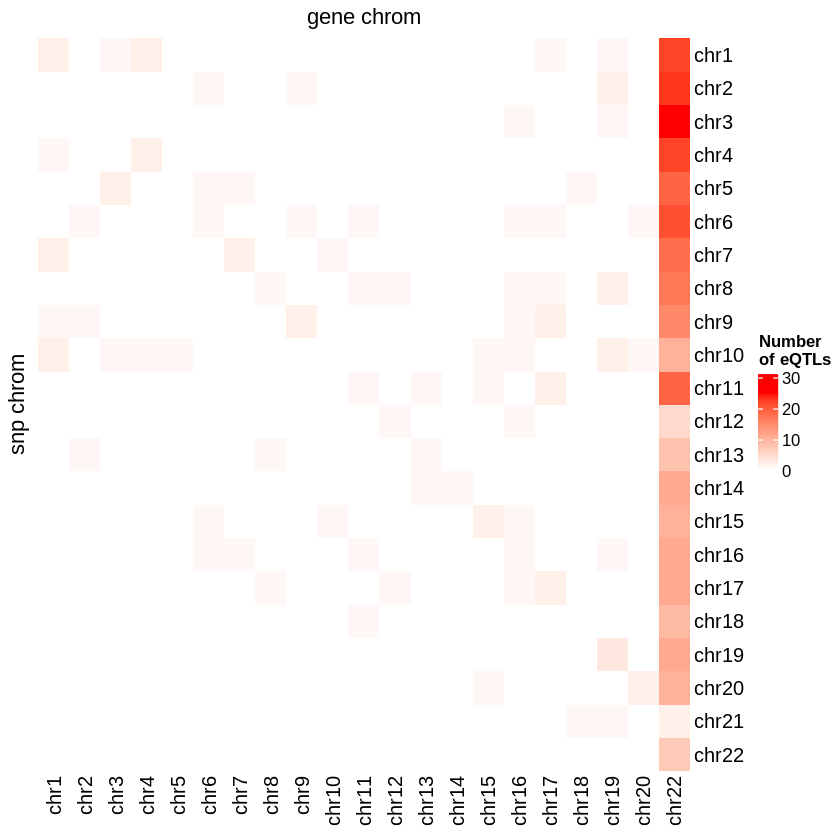

In [12]:
# all results (cis + trans)
col_fun = colorRamp2(c(0, max(mat)), c("white", "red"))
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [13]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"Plasma_trans_cis_heatmap_pv_5e_8.pdf"), width=10, height=10)
Heatmap(mat, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number \nof eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2

In [16]:
# trans only (different chromosome and or not within 2Mb of gene)
# df_combine_trans_only = df_combine[df_combine$cis.trans == "potential_novel"]
df_combine$cis.trans.2mb = "trans"
df_combine$snp_Chr = as.character(df_combine$snp_Chr)
df_combine[df_combine$gene_chr == df_combine$snp_Chr & df_combine$snp_Start >= df_combine$window_start & df_combine$snp_Start <= df_combine$window_end, "cis.trans.2mb"] = "cis"
table(df_combine$cis.trans.2mb)
df_combine_trans_only = df_combine[df_combine$cis.trans.2mb == "trans"]


  cis trans 
   26   373 

In [17]:
mat_trans=as.matrix(table(df_combine_trans_only$snp_Chr, df_combine_trans_only$gene_chr))
rownames(mat_trans)
colnames(mat_trans)

[1] "1"  "10" "11" "12" "13" "14" "15" "16" "17" "18" "19" "2"  "20" "21" "22"
[16] "3"  "4"  "5"  "6"  "7"  "8"  "9"

[1] "1"  "10" "11" "12" "13" "15" "16" "17" "18" "19" "2"  "20" "22" "3"  "4" 
[16] "5"  "6"  "7"  "8"  "9"

In [18]:
rownames(mat_trans) = paste0("chr",rownames(mat_trans))
colnames(mat_trans) = paste0("chr",colnames(mat_trans))
mat_trans = mat_trans[paste0("chr",1:22),paste0("chr",c(1:13,15:20,22))]

In [19]:
max(mat_trans)

[1] 25

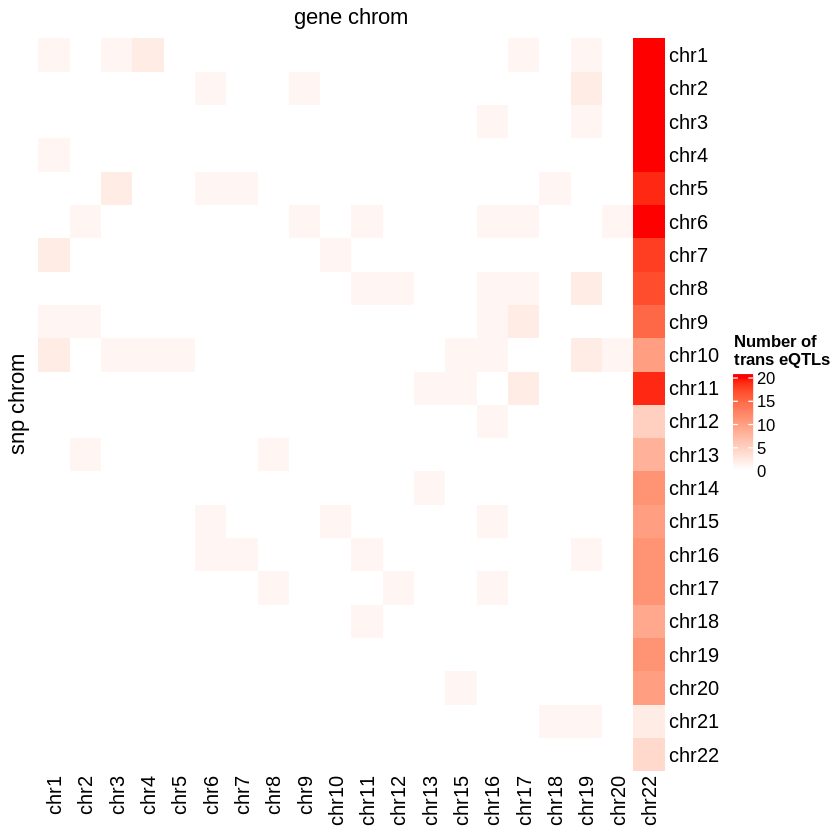

In [20]:
col_fun = colorRamp2(c(0, 20), c("white", "red"))
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)

In [21]:
fig_dir <- "/directflow/SCCGGroupShare/projects/anncuo/OneK1K/saige_eqtl/ms_figures/trans/"
pdf(paste0(fig_dir,"Plasma_trans_only_heatmap_pv_5e_8.pdf"), width=10, height=10)
Heatmap(mat_trans, cluster_rows = FALSE, cluster_columns = FALSE, name = "Number of \ntrans eQTLs", 
        row_title = "snp chrom", column_title = "gene chrom", col=col_fun)
dev.off()

png 
  2